In [1]:
# Langkah 1: Install dan Import Library
import pandas as pd
import sqlite3

# Langkah 2: Upload File
from google.colab import files
uploaded = files.upload()


Saving trans_bandung_ok.xlsx to trans_bandung_ok.xlsx


In [2]:
# Langkah 3: Baca Excel jadi DataFrame
df = pd.read_excel("trans_bandung_ok.xlsx")
df.head()


,acnot,trxdat,desc,amtrx,nom
0,94430,2017-01-25,ATM : BAYAR HA*******,83657.0,1
1,92057,2017-01-14,ATM : BAYAR HA*******,288737.0,2
2,90003,2017-01-26,ATM : BAYAR HA*******,233727.0,3
3,95245,2017-01-25,ATM : BAYAR HA*******,80648.0,4
4,90003,2017-01-26,ATM : BAYAR IN*******,105000.0,5


In [3]:
# Langkah 4: Buat database SQLite & simpan tabel
conn = sqlite3.connect("trans_bandung.db")
df.to_sql("transaksi", conn, index=False, if_exists="replace")

# Cek 5 baris pertama pakai SQL
pd.read_sql("SELECT * FROM transaksi LIMIT 5", conn)


,acnot,trxdat,desc,amtrx,nom
0,94430,2017-01-25,ATM : BAYAR HA*******,83657.0,1
1,92057,2017-01-14,ATM : BAYAR HA*******,288737.0,2
2,90003,2017-01-26,ATM : BAYAR HA*******,233727.0,3
3,95245,2017-01-25,ATM : BAYAR HA*******,80648.0,4
4,90003,2017-01-26,ATM : BAYAR IN*******,105000.0,5


In [4]:
# Contoh 1: Total transaksi per bulan
query = """
SELECT
    strftime('%Y', trxdat) AS Tahun,
    strftime('%m', trxdat) AS Bulan,
    SUM(amtrx) AS Total_Transaksi
FROM transaksi
GROUP BY Tahun, Bulan
ORDER BY Tahun, Bulan;
"""
pd.read_sql(query, conn)


,Tahun,Bulan,Total_Transaksi
0,2017,01,2.635901e+10
1,2017,02,6.204408e+10
2,2017,03,9.986765e+10
3,2017,04,6.536887e+10
4,2017,05,7.145318e+10
5,2017,06,6.919815e+10


In [5]:
# Contoh 2: Top 10 deskripsi transaksi
query2 = """
SELECT desc, SUM(amtrx) AS Total
FROM transaksi
GROUP BY desc
ORDER BY Total DESC
LIMIT 10;
"""
pd.read_sql(query2, conn)


,desc,Total
0,SETORAN TUNAI T*******,1.024089e+11
1,ATM : TRF KE B*******,3.554008e+10
2,ATM : BAYAR KK*******,2.194429e+10
3,PINBUK HASIL DR*******,2.000000e+10
4,TRF D/CENAIDJA *******,1.209213e+10
5,TRF D/BMRIIDJA *******,7.233002e+09
6,PINBUK DANA HSL*******,5.000000e+09
7,ATM : DR WOEN *******,4.996553e+09
8,TRF D/BRINIDJA *******,4.642502e+09
9,TRF DR *******,4.381566e+09


## Query SQL lanjutan (WHERE, LIKE, DISTINCT, dll)

# Tujuan
Menyaring dan memanipulasi data dengan query SQL

In [6]:
# WHERE: Menampilkan transaksi di atas 100.000
pd.read_sql("""
SELECT *
FROM transaksi
WHERE amtrx > 100000
LIMIT 10;
""", conn)


,acnot,trxdat,desc,amtrx,nom
0,92057,2017-01-14,ATM : BAYAR HA*******,288737.0,2
1,90003,2017-01-26,ATM : BAYAR HA*******,233727.0,3
2,90003,2017-01-26,ATM : BAYAR IN*******,105000.0,5
3,93368,2017-01-05,ATM : BAYAR KK*******,348000.0,6
4,92143,2017-01-26,ATM : BAYAR KK*******,5860000.0,7
5,91268,2017-01-31,ATM : BAYAR KK*******,2867000.0,8
6,91268,2017-01-12,ATM : BAYAR KK*******,2165000.0,9
7,90537,2017-01-20,ATM : BAYAR KK*******,563000.0,10
8,92143,2017-01-31,ATM : BAYAR KK*******,1500000.0,11
9,92143,2017-01-31,ATM : BAYAR KK*******,735000.0,12


In [7]:
# LIKE: Mencari deskripsi yang mengandung kata "topup"
pd.read_sql("""
SELECT *
FROM transaksi
WHERE desc LIKE '%topup%';
""", conn)


,acnot,trxdat,desc,amtrx,nom


In [8]:
# DISTINCT: Menampilkan semua jenis deskripsi unik
pd.read_sql("""
SELECT DISTINCT desc
FROM transaksi;
""", conn)


,desc
0,ATM : BAYAR HA*******
1,ATM : BAYAR IN*******
2,ATM : BAYAR KK*******
3,ATM : BAYAR LI*******
4,ATM : BAYAR MA*******
...,...
7924,TRF DR ZEN FANA*******
7925,TRF DR ZIPPORA *******
7926,TRF DR ZOLA PRI*******
7927,TRF DR ZULFIKRI*******


In [9]:
# BETWEEN: Transaksi antara 1 Januari - 31 Januari 2023
pd.read_sql("""
SELECT *
FROM transaksi
WHERE trxdat BETWEEN '2023-01-01' AND '2023-01-31';
""", conn)


,acnot,trxdat,desc,amtrx,nom


Opsi 2: Buat Tabel Terpisah & JOIN
🎯 Tujuan:
Latihan relasi antar tabel — dasar dari data warehouse/data mart.

📁 Simulasi: Buat Tabel akun dari kolom acnot

In [10]:
# Buat tabel akun unik (dummy)
akun = df[['acnot']].drop_duplicates().copy()
akun['nama'] = akun['acnot'].astype(str).apply(lambda x: f'Akun {x[-4:]}')

# Simpan ke SQLite
akun.to_sql("akun", conn, index=False, if_exists='replace')

# Contoh JOIN
pd.read_sql("""
SELECT t.acnot, a.nama, SUM(t.amtrx) AS total
FROM transaksi t
JOIN akun a ON t.acnot = a.acnot
GROUP BY t.acnot
ORDER BY total DESC
LIMIT 10;
""", conn)


,acnot,nama,total
0,91932,Akun 1932,2.500000e+10
1,94552,Akun 4552,6.078379e+09
2,92215,Akun 2215,5.782260e+09
3,91199,Akun 1199,5.070716e+09
4,91376,Akun 1376,4.004469e+09
5,93782,Akun 3782,4.000000e+09
6,91268,Akun 1268,3.923913e+09
7,94735,Akun 4735,3.850091e+09
8,94719,Akun 4719,3.797837e+09
9,94726,Akun 4726,3.686801e+09


In [11]:
result = pd.read_sql("""
SELECT desc, SUM(amtrx) AS total
FROM transaksi
GROUP BY desc
ORDER BY total DESC;
""", conn)

result.to_csv("ringkasan_desc.csv", index=False)
from google.colab import files
files.download("ringkasan_desc.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
result.to_excel("ringkasan_desc.xlsx", index=False)
files.download("ringkasan_desc.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Opsi 4: Visualisasi Hasil Query
📊 Contoh Visualisasi Top 10 Deskripsi

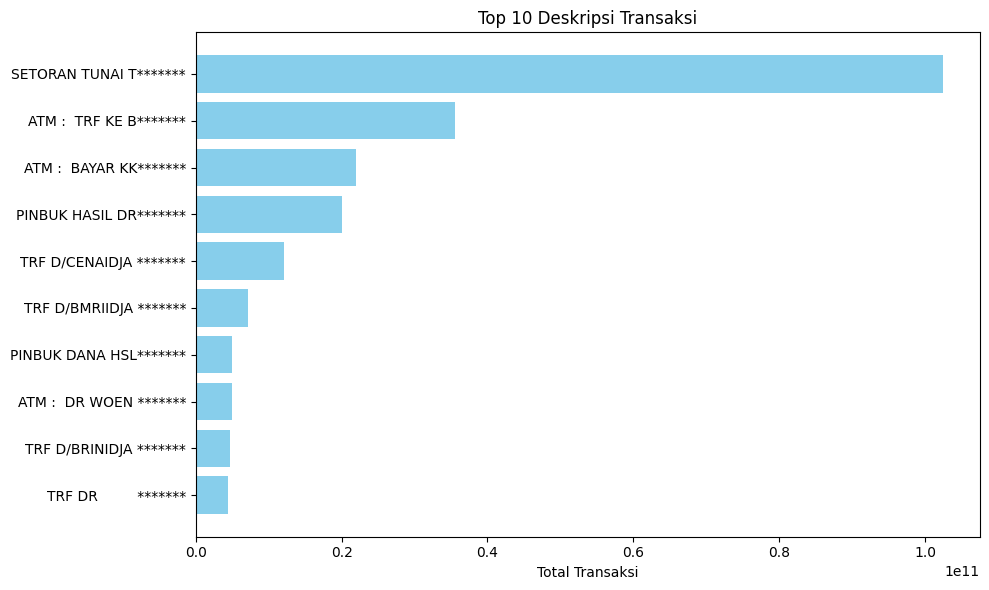

In [13]:
import matplotlib.pyplot as plt

query = """
SELECT desc, SUM(amtrx) AS total
FROM transaksi
GROUP BY desc
ORDER BY total DESC
LIMIT 10;
"""

df_viz = pd.read_sql(query, conn)

plt.figure(figsize=(10, 6))
plt.barh(df_viz['desc'], df_viz['total'], color='skyblue')
plt.gca().invert_yaxis()
plt.title("Top 10 Deskripsi Transaksi")
plt.xlabel("Total Transaksi")
plt.tight_layout()
plt.show()
